## Model Interpretation for the 2-layer multiple output Neural Network

### Variable Importance

Import some modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import brier_score_loss, roc_curve, roc_auc_score

Read in input array

In [4]:
inputdata = np.load(file="lhc_100.npy", allow_pickle=True)

List of input variables

In [5]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read in output array; calculated in SVD.py after processing in outputdata/process_outputdata_SVD.ncl

In [6]:
outputdata_GPP = np.load(file="outputdata/outputdata_GPP_SVD_3modes.npy",
        allow_pickle=True)
outputdata_LHF = np.load(file="outputdata/outputdata_LHF_SVD_3modes.npy",
        allow_pickle=True)
nmodes = outputdata_GPP.shape[1]

Import trained NN; save in NN_finalize_multi-dim.py

In [1]:
import keras.backend as K
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)
from keras.models import load_model
model_GPP = load_model('emulators/NN_GPP_finalize_multi-dim.h5', custom_objects={'mean_sq_err':
    mean_sq_err})
model_LHF = load_model('emulators/NN_LHF_finalize_multi-dim.h5',
    custom_objects={'mean_sq_err': mean_sq_err})

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

Test model predictions

In [7]:
#model_preds_GPP = model_GPP.predict(inputdata)
#model_preds_LHF = model_LHF.predict(inputdata)

Define score for predictions

In [8]:
def mse_preds(y_true,y_pred):
    return np.mean((y_true-y_pred)**2, axis=0)

In [9]:
#mse_preds(outputdata_GPP,model_preds_GPP)

Define function for feature importance by shuffling

In [10]:
def permutation_feature_importance(input_data, output_data, model, score=mse_preds):
    model_preds = model.predict(input_data)
    original_error = score(output_data, model_preds)
    permuted_scores = np.zeros((input_data.shape[1], nmodes))
    permuted_data = np.copy(input_data)
    permuted_indices = np.arange(input_data.shape[0])
    for c in range(input_data.shape[1]):
        np.random.shuffle(permuted_indices)
        permuted_data[:, c] = input_data[permuted_indices, c]
        permuted_preds = model.predict(permuted_data)                                                                                                                     
        permuted_scores[c, :] = score(output_data,permuted_preds)
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [11]:
#permuted_indices = np.arange(inputdata.shape[0])
#permuted_indices
#np.random.shuffle(permuted_indices)
#permuted_indices
#permuted_scores = np.zeros((inputdata.shape[1], nmodes))
#permuted_scores.shape

Calculate feature importance

In [12]:
gpp_original, gpp_permuted = permutation_feature_importance(inputdata,
        outputdata_GPP, model_GPP)
lhf_original, lhf_permuted = permutation_feature_importance(inputdata,
        outputdata_LHF, model_LHF)

In [13]:
#print(gpp_original, gpp_permuted)
#gpp_permuted.shape[0]
#gpp_original[1]

In [14]:
#m=2
#print("EOF%i GPP MSE" %m) 
#range(nmodes)

Plot importance (larger bar is more important)

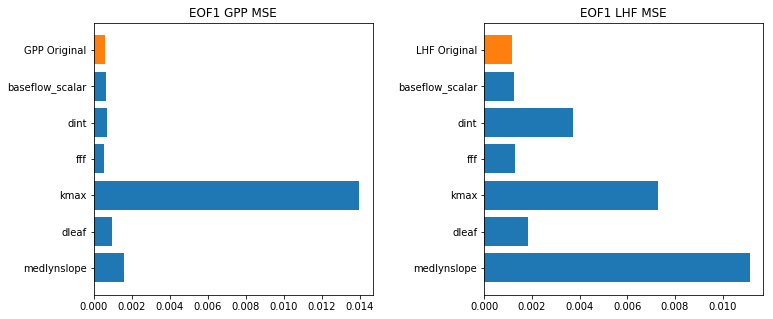

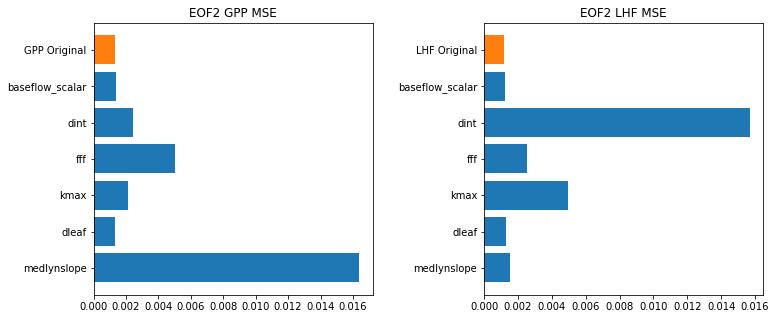

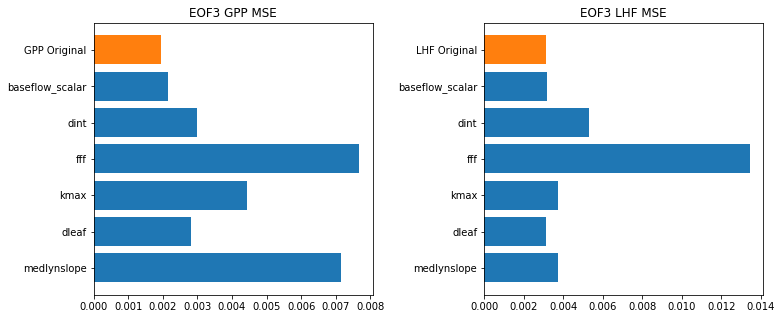

In [15]:
for m in range(nmodes):
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(gpp_permuted.shape[0]), gpp_permuted[:,m])
    plt.barh(gpp_permuted.shape[0], gpp_original[m])
    plt.yticks(np.arange(gpp_permuted.shape[0] + 1),
        in_vars + ["GPP Original"])
    mode=m+1
    plt.title("EOF%i GPP MSE" %mode)
    plt.subplot(1, 2, 2)
    plt.barh(np.arange(lhf_permuted.shape[0]), lhf_permuted[:,m])
    plt.barh(lhf_permuted.shape[0], lhf_original[m])
    plt.yticks(np.arange(lhf_permuted.shape[0] + 1),
        in_vars + ["LHF Original"])
    plt.title("EOF%i LHF MSE" %mode)    
    #plt.savefig('variable_importance_GPP_LHF_SVD_mode%i.pdf' %mode)

Try defining feature importance by setting one parameter at a time to fixed scaling value (instead of random shuffling existing values)

In [16]:
def permutation_feature_importance_v2(input_data, output_data, model, score=mse_preds):
    model_preds = model.predict(input_data)
    original_error = score(output_data, model_preds)
    permuted_scores = np.zeros((input_data.shape[1], nmodes))
    permuted_data = np.copy(input_data)
    for c in range(input_data.shape[1]):
        permuted_data[:, c] = 0.5*np.ones(input_data.shape[0])
        permuted_preds = model.predict(permuted_data)                                                                                                                     
        permuted_scores[c, :] = score(output_data,permuted_preds)
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [17]:
gpp_original_v2, gpp_permuted_v2 = permutation_feature_importance_v2(inputdata,
        outputdata_GPP, model_GPP)
lhf_original_v2, lhf_permuted_v2 = permutation_feature_importance_v2(inputdata,
        outputdata_LHF, model_LHF)

In [18]:
#print(gpp_original_v2, gpp_permuted_v2)

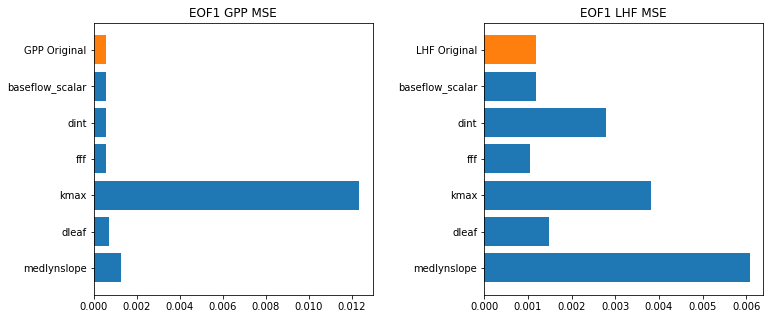

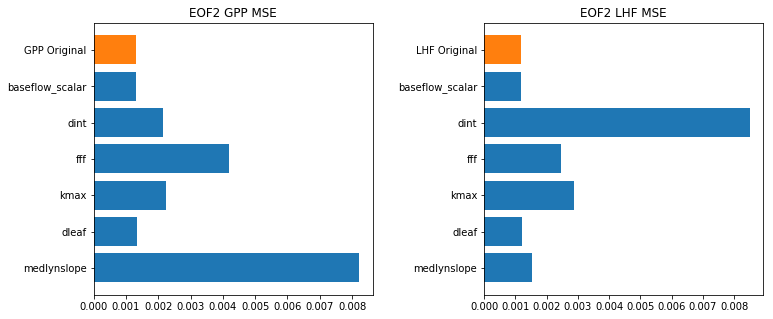

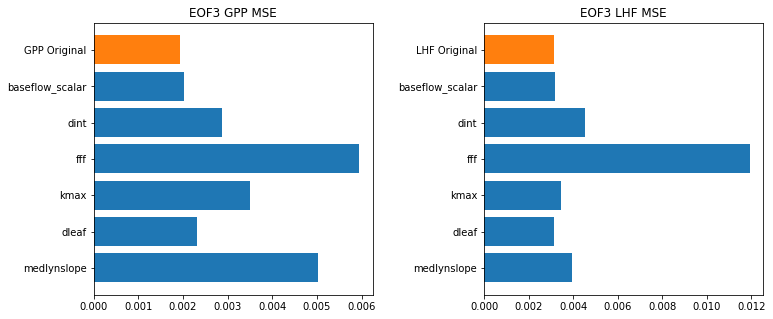

In [19]:
for m in range(nmodes):
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(gpp_permuted_v2.shape[0]), gpp_permuted_v2[:,m])
    plt.barh(gpp_permuted_v2.shape[0], gpp_original_v2[m])
    plt.yticks(np.arange(gpp_permuted_v2.shape[0] + 1),
        in_vars + ["GPP Original"])
    mode=m+1
    plt.title("EOF%i GPP MSE" %mode)
    plt.subplot(1, 2, 2)
    plt.barh(np.arange(lhf_permuted_v2.shape[0]), lhf_permuted_v2[:,m])
    plt.barh(lhf_permuted_v2.shape[0], lhf_original_v2[m])
    plt.yticks(np.arange(lhf_permuted_v2.shape[0] + 1),
        in_vars + ["LHF Original"])
    plt.title("EOF%i LHF MSE" %mode)

Fix all but one parameter, and vary one at a time. Results should be different; a way to test parameter interactions (nonlinearities)

In [20]:
def permutation_feature_importance_varyone(input_data, output_data, model, score=mse_preds):
    model_preds = model.predict(input_data)
    original_error = score(output_data, model_preds)
    permuted_scores = np.zeros((input_data.shape[1], nmodes))
    permuted_data = np.copy(input_data)
    permuted_indices = np.arange(input_data.shape[0])
    for c in range(input_data.shape[1]):
        for p in range(input_data.shape[1]):
            np.random.shuffle(permuted_indices)
            permuted_data[:, p] = input_data[permuted_indices, p] # reshuffle all columns with a different random shuffling
        permuted_data[:, c] = input_data[:, c] # preserve one column
        permuted_preds = model.predict(permuted_data)
        permuted_scores[c, :] = score(output_data,permuted_preds)
        permuted_data = np.copy(input_data)
    return original_error, permuted_scores

In [21]:
gpp_original_varyone, gpp_permuted_varyone = permutation_feature_importance_varyone(inputdata,
        outputdata_GPP, model_GPP)
lhf_original_varyone, lhf_permuted_varyone = permutation_feature_importance_varyone(inputdata,
        outputdata_LHF, model_LHF)

In [22]:
#print(gpp_original_varyone, gpp_permuted_varyone)

Plot importance (smaller bar is more important)

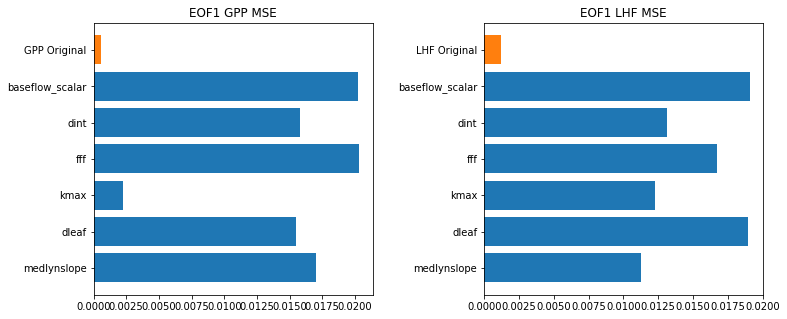

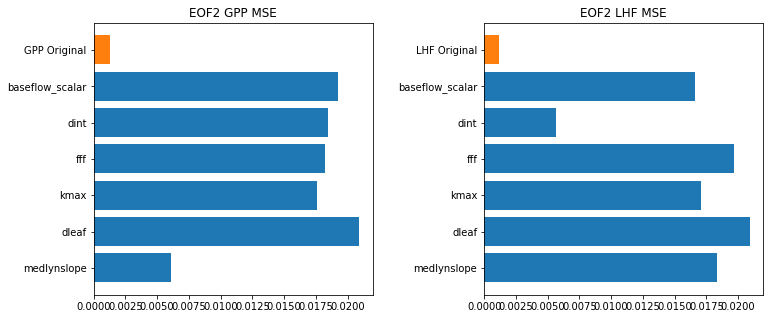

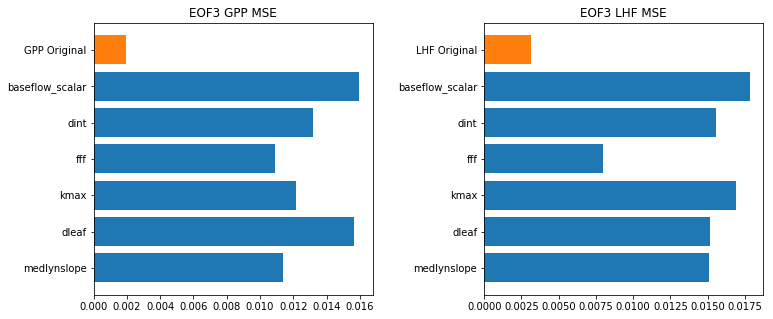

In [23]:
for m in range(nmodes):
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(gpp_permuted_varyone.shape[0]), gpp_permuted_varyone[:,m])
    plt.barh(gpp_permuted_varyone.shape[0], gpp_original_varyone[m])
    plt.yticks(np.arange(gpp_permuted_varyone.shape[0] + 1),
        in_vars + ["GPP Original"])
    mode=m+1
    plt.title("EOF%i GPP MSE" %mode)
    plt.subplot(1, 2, 2)
    plt.barh(np.arange(lhf_permuted_varyone.shape[0]), lhf_permuted_varyone[:,m])
    plt.barh(lhf_permuted_varyone.shape[0], lhf_original_varyone[m])
    plt.yticks(np.arange(lhf_permuted_varyone.shape[0] + 1),
        in_vars + ["LHF Original"])
    plt.title("EOF%i LHF MSE" %mode)    
    #plt.savefig('variable_importance_varyone_GPP_LHF_SVD_mode%i.pdf' %mode)

### Partial Dependence Plots

Test why a certain variable is important and plot where in the inputdata values are important

In [7]:
def partial_dependence_plot(input_data, model, points=10):
    pd_points = np.zeros((input_data.shape[1], points))
    pd_pred_vals = np.zeros((input_data.shape[1], points, input_data.shape[0], nmodes))
    fixed_data = np.copy(input_data)
    for i in range(input_data.shape[1]):
        print(i)
        pd_points[i] = np.linspace(input_data[:, i].min(), input_data[:, i].max(), points)
        for p, point in enumerate(pd_points[i]):
            fixed_data[:, i] = point
            pd_pred_vals[i, p] = model.predict(fixed_data)
        fixed_data[:, i] = input_data[:, i]
    return pd_points, pd_pred_vals

In [15]:
#pd_points = np.zeros((inputdata.shape[1], 10, inputdata.shape[0], nmodes))
#pd_points.shape
#pd_pred_vals = np.zeros((inputdata.shape[1], 10, inputdata.shape[0]))
pd_points = np.zeros((inputdata.shape[1], 10))
pd_points.shape
pd_points[0] = np.linspace(inputdata[:, 0].min(), inputdata[:, 0].max(), 10)
print(pd_points[0])
#print(inputdata[:,0].min())
#fixed_data = np.copy(inputdata)
#fixed_data[:,0] = inputdata[:,0].min()
#pd_points
#model_GPP.predict(inputdata).shape

[0.00479822 0.11513935 0.22548048 0.3358216  0.44616273 0.55650385
 0.66684498 0.7771861  0.88752723 0.99786835]


In [19]:
GPP_pd_points, GPP_pd_pred_vals = partial_dependence_plot(inputdata, model_GPP)
GPP_pd_pred_vals.shape
#GPP_pd_pred_vals.T.shape
#print(GPP_pd_points)

0
1
2
3
4
5


(6, 10, 100, 3)

In [17]:
LHF_pd_points, LHF_pd_pred_vals = partial_dependence_plot(inputdata, model_LHF)

0
1
2
3
4
5


In [28]:
#fig, axes = plt.subplots(3, 2, figsize=(8, 12))
#axef=axes.ravel()
#axef[0]
#random_rows = np.random.randint(0, inputdata.shape[0], size=100)
#random_rows

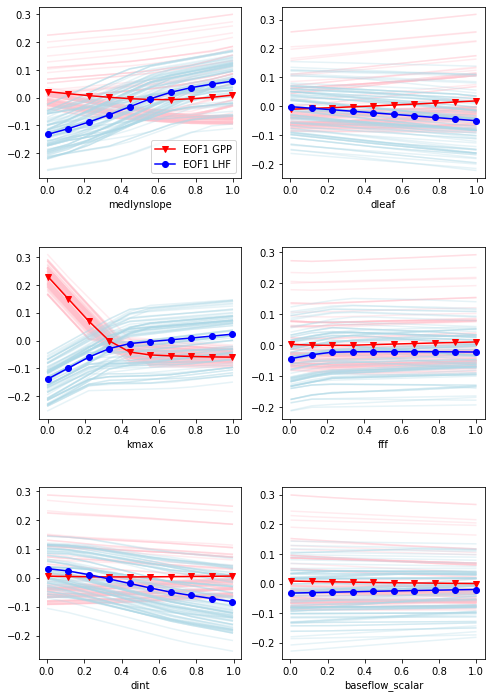

In [18]:
m = range(nmodes)[0] # set mode
mode = m+1
fig, axes = plt.subplots(3, 2, figsize=(8, 12)) # set up subplots (3 rows, 2 columns)
plt.subplots_adjust(hspace=0.4) # adjust height between subplots
axef = axes.ravel() # enumerate(?) the subplot axes so they are callable
random_rows = np.random.randint(0, inputdata.shape[0], size=100)
for i in range(inputdata.shape[1]):
    axef[i].plot(GPP_pd_points[i], GPP_pd_pred_vals[i, :, random_rows, m].T, color="pink", alpha=0.3)
    axef[i].plot(LHF_pd_points[i], LHF_pd_pred_vals[i, :, random_rows, m].T, color="lightblue", alpha=0.3)
    axef[i].plot(GPP_pd_points[i], GPP_pd_pred_vals[i,:,:,m].mean(axis=1), marker='v', color="red", label="EOF%i GPP" %mode)
    axef[i].plot(LHF_pd_points[i], LHF_pd_pred_vals[i,:,:,m].mean(axis=1), marker='o', color="blue", label="EOF%i LHF" %mode)
    if i == 0:
        axef[i].legend()
    axef[i].set_xlabel(in_vars[i])
#plt.savefig('partial_dep_GPP_LHF_SVD_mode%i.pdf' %mode)

### iNNvestigate toolbox

In [8]:
import innvestigate

Create analyzer

In [9]:
#analyzer = innvestigate.create_analyzer("gradient", model_GPP)
analyzer_DT = innvestigate.create_analyzer("deep_taylor", model_GPP)

Analyze the influence of the inputdata

In [10]:
analysis = analyzer_DT.analyze(inputdata)

In [11]:
analysis.shape
#inputdata.shape

(100, 6)

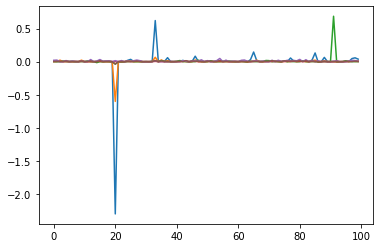

In [13]:
plt.plot(analysis)
#plt.plot(inputdata[2,:])
#plt.scatter(inputdata[:,0], analysis[:,0])
#plt.contourf(analysis)
#plt.colorbar()

In [35]:
np.sum(abs(analysis), axis=0)

array([3.9594574 , 1.0244685 , 0.99205536, 0.17503658, 0.84424245,
       0.39285243], dtype=float32)

Analyze neuron with specified index

In [36]:
analyzer_DT_2 = innvestigate.create_analyzer("deep_taylor", model_GPP, neuron_selection_mode="index")
analysis_2 = analyzer_DT_2.analyze(inputdata, 0)

In [37]:
analysis_2.shape

(100, 6)

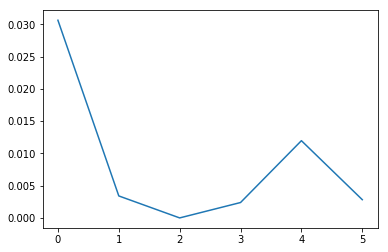

In [38]:
plt.plot(analysis_2[1,:])

Bounded Deep Taylor

In [39]:
input_range = [0,1]
bounds = {"low": input_range[0], "high": input_range[1]}
analyzer_DT_b = innvestigate.create_analyzer("deep_taylor.bounded", model_GPP, **bounds)

In [40]:
analysis_b = analyzer_DT_b.analyze(inputdata)

In [41]:
analysis_b.shape

(100, 6)

array([ 3.76118766e-03,  8.44826864e-04,  2.16654334e-02,  2.73120916e-03,
        4.58946405e-03,  1.87334453e-03,  4.93658567e-03, -1.13861496e-03,
       -7.67641759e-04,  1.62516031e-02,  0.00000000e+00,  4.22199816e-03,
        3.41406325e-03, -1.07973011e-03, -6.42933510e-03,  3.78923630e-03,
       -1.20861479e-03,  2.94672884e-03, -1.82176079e-03, -1.23525865e-03,
       -1.64905763e+00, -1.02512783e-03, -4.61265910e-03, -1.85034226e-03,
        1.09666055e-02,  1.70152783e-02,  1.08196423e-03,  1.18077360e-03,
        2.16062297e-03, -1.32244278e-03,  0.00000000e+00, -2.04649265e-03,
        2.84730387e-03,  3.38271946e-01, -1.90598657e-04,  1.18325055e-02,
        2.78029358e-03,  2.83008665e-02, -1.55047281e-03,  0.00000000e+00,
        1.49336993e-03,  6.37596194e-03,  1.10677909e-02,  4.24318062e-03,
       -1.33121479e-03,  9.69888992e-04,  3.77672873e-02,  5.25011355e-03,
        2.93511385e-03,  0.00000000e+00,  1.83407543e-03,  3.78540251e-03,
        5.21029579e-05,  

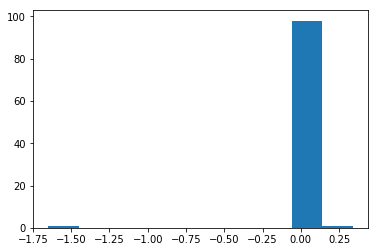

In [51]:
#plt.plot(analysis_b[2,:])
#plt.plot(inputdata[2,:])
#plt.contourf(analysis_b)
#plt.colorbar()
plt.hist(analysis_b[:,0])
analysis_b[:,0]

In [43]:
bounds

{'low': 0, 'high': 1}

### How to interpret the output of the analyzer?